# **Intrusion Detection**


## Introduction.

The purpose of this project is to train and evaluate multiple models that can classify flows and recognize different types of attacks, i.e., models used for multiclass classification tasks.

The dataset used is the NSL-KDD dataset (KDDTrainClean.csv) which is a benchmark for *Intrusion Detection* systems. The dataset contains information about network flows to an IT infrastructure. Each flow is labeled as “normal” or associated with an attack type where the *label* column represents the label.

Translated with DeepL.com (free version)

In [ ]:
# Import

import os
import logging
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow as tf
import seaborn as sns
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Ignore warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.get_logger().setLevel(logging.ERROR)
os.environ['PYTHONWARNINGS'] = 'ignore'
logging.getLogger('tensorflow').setLevel(logging.ERROR)

2025-01-30 09:48:41.940648: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-30 09:48:41.946915: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-30 09:48:42.004160: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-30 09:48:42.059908: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738226922.115429   22332 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738226922.13

In [22]:
# Load dataset
dataset_path = "./KDDTrainClean.csv"
dataset = pd.read_csv(dataset_path)

# To verify that the daset is loaded correctly, I count the rows in the dataset itself.
print(f"Number of samples in the dataset :{len(dataset)}")

# Get information about the dataset in use.
print(dataset.info())

Number of samples in the dataset :125973
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised  

## Data Analysis & Data Preprocessing.

First, it was decided to do a preliminary analysis of the data within the dataset, analyzing the number of classes and their distribution.

In [23]:
# Preliminary Analysis
target_column = "label"
features = dataset.columns.difference([target_column])

class_counts = dataset[target_column].value_counts()

# Let's visualize the distribution of classes
print("Class distribution:")
print(dataset[target_column].value_counts())

Class distribution:
label
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64


A bar graph is used to represent the distribution.

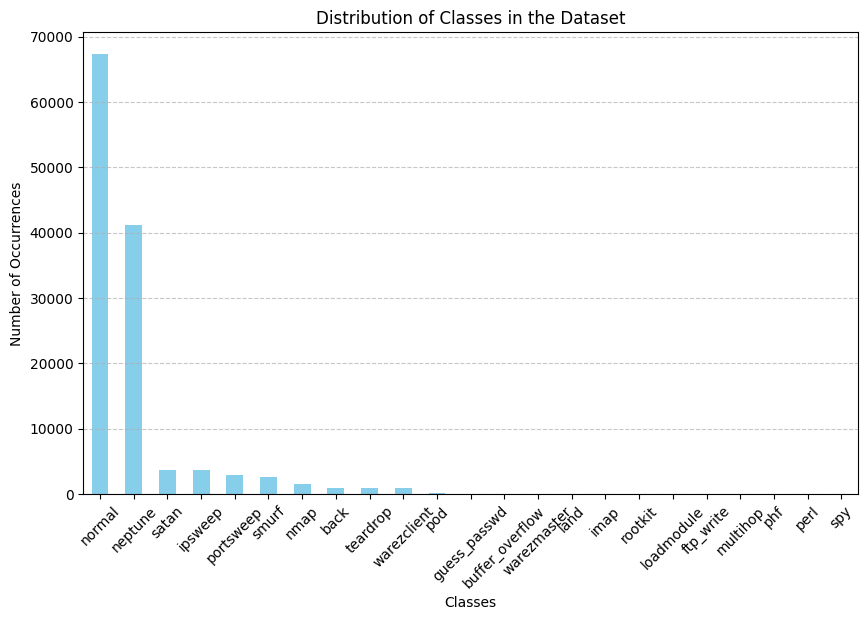

In [24]:
class_counts.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Distribution of Classes in the Dataset')
plt.xlabel('Classes')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

It can be seen that the dataset is unbalanced for certain types of classes and this could lead to overfitting behavior for those particular most common classes which would result in the models used for the task not being able to generalize better and not being able to recognize the rarer cases that are not as common within the dataset.

In fact, the classes '*guess_passwd*', '*buffer_overflow*', '*warezmaster*', '*land*', '*imap*', '*rootkit*', '*loadmodule*', '*ftp_write*', '*multihop*', '*phf*', '*perl*', and '*spy*' repeatedly have less than 100 tuples within the dataset, some even less than 10. The models may not be able to succeed in classifying the instances correctly.

To try to solve this problem, one could think of introducing synthetic data, then using the **dataset agumentation** technique. This would solve the problem of rebalancing the classes so that the less common classes are in sufficient numbers so that the models can learn efficiently, adding synthetic data would lead to improve the ability of the models to generalize by reducing the overfitting on the dominant classes and it would reduce the imbalance so that better performance is achieved.

There are, however, considerations to be made about the addition of synthetic data:
- the synthetic data that are added must be realistic and consistent with the problem domain, in case they are not it could adversely affect the performance of the models;
- one could fall into cases of overfitting because creating synthetic data for rare classes could cause the models to memorize artificial patterns rather than learning general features;
- if the synthetic data being generated were used in both training and testing phases it could provide an optimistic picture of the performance of the models being built.

To try to use the idea of using syntactic data to obtain the benefits of generalization but trying to limit its use, a targeted approach is used. It uses **Smote (Synthetic Minority Over-sampling Technique)** in such a way as to generate synthetic examples by interpolating real class data while limiting its use to only rare classes, i.e., only the precendently mentioned classes. 

In [25]:
# I count the occurrences for individual classes
class_counts = dataset[target_column].value_counts()

# I define a threshold value so that the rarest classes can be identified
threshold = 100 

# I find classes below the threshold
underrepresented_classes = class_counts[class_counts < threshold].index
print("Classes below the threshold:", underrepresented_classes)

Classes below the threshold: Index(['guess_passwd', 'buffer_overflow', 'warezmaster', 'land', 'imap',
       'rootkit', 'loadmodule', 'ftp_write', 'multihop', 'phf', 'perl', 'spy'],
      dtype='object', name='label')


Before applying **SMOTE** we need to transform those features that are not numerical data. 

In [ ]:
# I divide the dataset into features and targets
X = dataset.drop(columns=[target_column])
y = dataset[target_column]

number_of_classes = dataset[target_column].nunique()

# I identify categorical columns.
categorical_columns = X.select_dtypes(include=['object']).columns
numeric_columns = X.select_dtypes(exclude=['object']).columns

# I configure the encoder for categorical features
features_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns),
        ('num', 'passthrough', numeric_columns)
    ]
)

# I transform columns
X_encoded = features_preprocessor.fit_transform(X)

X_encoded = pd.DataFrame(
    X_encoded.toarray() if hasattr(X_encoded, 'toarray') else X_encoded,
    columns=features_preprocessor.get_feature_names_out()
).astype(float)


print(X_encoded.dtypes)
X_encoded = X_encoded.astype(float)


cat__protocol_type_icmp             float64
cat__protocol_type_tcp              float64
cat__protocol_type_udp              float64
cat__service_IRC                    float64
cat__service_X11                    float64
                                     ...   
num__dst_host_srv_diff_host_rate    float64
num__dst_host_serror_rate           float64
num__dst_host_srv_serror_rate       float64
num__dst_host_rerror_rate           float64
num__dst_host_srv_rerror_rate       float64
Length: 122, dtype: object


In [7]:
# I do the encoding of the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_one_hot = to_categorical(y_encoded)

However, there is a problem, **SMOTE** cannot be applied for classes with too few instances, especially for the class with only one training example. It was decided to apply **SMOTE** only for those classes with at least 2 training instances. Another possible method that was thought to apply is to duplicate the only instance present, but this would not bring any particular benefits because then synthetic data would be generated on copies of the one example.

In [8]:
# I divide into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_one_hot, test_size=0.3, random_state=42)

# I have to encode the labels of the least represented classes, but in this case I have to act at the numerical level after encoding
threshold = 2
class_counts = pd.Series(y_encoded).value_counts()
underrepresented_classes = class_counts[class_counts < threshold].index

# This is only done for classes that have too few samples to then apply SMOTE correctly.
for class_label in underrepresented_classes:
    
    class_indices = np.where(y_train == class_label)[0]
    
    # I calculate the number of duplications needed.
    # Need at least 2 samples per class to apply SMOTE, is the minimum number.
    num_duplicates = max(0, 2 - len(class_indices))  
    
    # Duplicate samples
    duplicated_samples = X_train.iloc[class_indices].sample(num_duplicates, replace=True, random_state=42)
    X_train = pd.concat([X_train, duplicated_samples])
    y_train = pd.concat([y_train, pd.Series(np.repeat(class_label, num_duplicates).tolist(), dtype=int)], ignore_index=True)


# I create a dictionary with the desired number of instances for each rare class within the dataset.
desired_instances = {class_label: 100 for class_label in underrepresented_classes} 

In [9]:
# I apply SMOTE
smote = SMOTE(sampling_strategy=desired_instances, random_state=42, k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

X_resampled = X_resampled.astype(float)

As a last thing, you divide the training set into training set and validation set after applying **SMOTE**.

In [ ]:
# I divide the training set into training set and validation set
X_training, X_validation, y_training, y_validation = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

print("Taglia del Training Set:     ", len(X_training))
print("Taglia del Validation Set:   ", len(X_validation))
print("Taglia del Testing Set:      ", len(X_test))

Taglia del Training Set:      61726
Taglia del Validation Set:    26455
Taglia del Testing Set:       37792


## Definition of Metrics Used

The metrics used to evaluate the performance of the models used are:
- **Accuracy**;
- **Precision**;
- **Recall**;
- **F1-Score**.

A confusion matrix can also be added.

In [11]:
# Defining a function to evaluate the model evaluation metrics used for the task of interest.
def evaluate_model(y_true, y_pred):
    metrics = {}

    # Accuracy
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)

    # Precision
    metrics['Precision'] = precision_score(y_true, y_pred, average='weighted')

    # Recall
    metrics['Recall'] = recall_score(y_true, y_pred, average='weighted')

    # F1-Score
    metrics['F1-Score'] = f1_score(y_true, y_pred, average='weighted')

    return metrics

# Note: to get more accurate assessments you can use the same metrics but “by class,” it is also useful to use a cunfuzion matrix. 

## Implementation of Models.

At this point it was decided to implement the models, train them, and evaluate their performance.
In order to compare the values of the metrics, a dictionary is used to maintain the performance of the various models used.

In [12]:
models_metrics_dataset_agumentation = {}

### Random Forest

A first model decided to use is the Random Forest; RandomizedSearchCV is used for tuning the hyperparameters.

In [ ]:
# Random Forest model initialization.
random_forest_model = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],                              # Number of trees in the window
    'max_depth': [10, 15, 20, 25, 30, 35, None],                                                    # Maximum tree depth
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],      # Minimum number of samples to split a node
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],                                            # Minimum number of samples that a leaf node must contain
    'max_features': ['auto', 'sqrt', 'log2'],                                                       # Number of features to be considered for node division
    'bootstrap': [True, False],                                                                     # Whether or not to use bootstrap
    'criterion': ['gini', 'entropy'],                                                               # Division criterion
    'class_weight': ['balanced', None]                                                              # Class weights
}

random_search = RandomizedSearchCV(
    estimator=random_forest_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_resampled, y_resampled)
best_params = random_search.best_params_
print("Best hyperparameters:", random_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'n_estimators': 250, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'criterion': 'entropy', 'class_weight': 'balanced', 'bootstrap': False}


In [18]:
# Model training with all training data
final_random_forest_model = RandomForestClassifier(**best_params, random_state=42)
final_random_forest_model.fit(X_training, y_training)

y_pred_rf = final_random_forest_model.predict(X_validation)

In [19]:
# I evaluate the performance of the model on the validation set

metrics_rf = evaluate_model(y_validation, y_pred_rf)
models_metrics_dataset_agumentation['Random Forest'] = metrics_rf

Once the model has been evaluated, the results obtained are shown.

In [20]:
print("Accuracy Random Forest:              " + str(models_metrics_dataset_agumentation['Random Forest']['Accuracy']))
print("Precision Random Forest:             " + str(models_metrics_dataset_agumentation['Random Forest']['Precision']))
print("Recall Random Forest:                " + str(models_metrics_dataset_agumentation['Random Forest']['Recall']))
print("F1-Score Random Forest:              " + str(models_metrics_dataset_agumentation['Random Forest']['F1-Score']))

Accuracy Random Forest:              0.996938196938197
Precision Random Forest:             0.9985243908322246
Recall Random Forest:                0.996938196938197
F1-Score Random Forest:              0.9976790523141003


**K-Nearest Neighbors (KNN)**

As the second model, KNN was chosen.<br>
Similarly to the first model, RandomizedSearchCV was used to obtain the best hyperparameters.

In [13]:
model_name = "KNN"

param_dist = {
    'n_neighbors': np.arange(1, 31),                                                # Number of neighbors to use
    'weights': ['uniform', 'distance'],                                             # Weight function used for prediction
    'metric': ['euclidean', 'manhattan', 'chebyshev'],                              # Distance Metric
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],                         # Algorithm used to find neighbors
}

knn_model = KNeighborsClassifier()

# Configuring RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=knn_model,
    param_distributions=param_dist,
    n_iter=30,                                                                      # Number of parameter configurations sampled
    cv=5,                                                                           # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)


random_search.fit(X_resampled, y_resampled)
best_params = random_search.best_params_
print("Best hyperparameters:", random_search.best_params_)

Best hyperparameters: {'weights': 'distance', 'n_neighbors': np.int64(2), 'metric': 'manhattan', 'algorithm': 'auto'}


In [ ]:
# Training the model with all the training data
final_knn_model = KNeighborsClassifier(**best_params)
final_knn_model.fit(X_training, y_training)

y_pred_knn = final_knn_model.predict(X_validation)

In [15]:
# I evaluate the model performance on the validation set

metrics_knn = evaluate_model(y_validation, y_pred_knn)
models_metrics_dataset_agumentation['KNN'] = metrics_knn

Once the model has been evaluated, the results obtained are shown.

In [16]:
print("Accuracy KNN:              " + str(models_metrics_dataset_agumentation['KNN']['Accuracy']))
print("Precision KNN:             " + str(models_metrics_dataset_agumentation['KNN']['Precision']))
print("Recall KNN:                " + str(models_metrics_dataset_agumentation['KNN']['Recall']))
print("F1-Score KNN:              " + str(models_metrics_dataset_agumentation['KNN']['F1-Score']))

Accuracy KNN:              0.9885465885465885
Precision KNN:             0.9885353116387315
Recall KNN:                0.9885465885465885
F1-Score KNN:              0.9884482570059129


### Deep Neural Network

A final model that was decided to use is a natural network.

In [ ]:
num_features = X_resampled.shape[1]
num_classes = y_resampled.shape[1]

nn_model = Sequential()

nn_model.add(Dense(64, input_dim=num_features, activation='softmax'))
nn_model.add(Dense(150, activation='softmax'))
nn_model.add(Dense(200, activation='softmax'))
nn_model.add(Dense(100, activation='softmax'))
nn_model.add(Dense(num_classes, activation='softmax'))

nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=20,         
    restore_best_weights=True  
)

# Model training
history = nn_model.fit(
    X_training, y_training,
    validation_data=(X_validation, y_validation),  
    epochs=300,            
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

W0000 00:00:1738229182.186951   22332 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/300
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5345 - loss: 2.1686 - val_accuracy: 0.5405 - val_loss: 1.2442
Epoch 2/300
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7454 - loss: 0.9253 - val_accuracy: 0.8564 - val_loss: 0.6705
Epoch 3/300
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8558 - loss: 0.6571 - val_accuracy: 0.8864 - val_loss: 0.5135
Epoch 4/300
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8836 - loss: 0.4974 - val_accuracy: 0.8846 - val_loss: 0.4649
Epoch 5/300
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8844 - loss: 0.4538 - val_accuracy: 0.9033 - val_loss: 0.4157
Epoch 6/300
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8888 - loss: 0.4174 - val_accuracy: 0.9041 - val_loss: 0.3875
Epoch 7/300
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8970 - loss: 0.4149 - val_accuracy: 0.8893 - val_loss: 0.4219
Epoch 8/300
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8971 - loss: 0

In [26]:
y_pred_nn = nn_model.predict(X_validation)

y_validation_label = np.argmax(y_validation, axis=1)
y_pred_nn_label = np.argmax(y_pred_nn, axis=1)

metrics_nn = evaluate_model(y_validation_label, y_pred_nn_label)

models_metrics_dataset_agumentation['NN'] = metrics_nn

print("Accuracy NN:              " + str(models_metrics_dataset_agumentation['NN']['Accuracy']))
print("Precision NN:             " + str(models_metrics_dataset_agumentation['NN']['Precision']))
print("Recall NN:                " + str(models_metrics_dataset_agumentation['NN']['Recall']))
print("F1-Score NN:              " + str(models_metrics_dataset_agumentation['NN']['F1-Score']))

827/827 ━━━━━━━━━━━━━━━━━━━━ 1s 927us/step
Accuracy NN:              0.9706293706293706
Precision NN:             0.9487900952320234
Recall NN:                0.9706293706293706
F1-Score NN:              0.9592716066044076


During the neural network testing phase, another approach was also considered to try to improve the model's performance.

In fact, for the other models considered, the model structure was not manually set but an approach based on *RandomizedSearchCV* was used to return the best parameters for the models considered, namely *Random Forest* and *KNN*.

Therefore, it was thought to use a similar approach, therefore to use an automatic approach to search for the parameters to use.

As regards the neural network, the use of *Keras Tuner* was considered to obtain the best parameters to use in the model; during the testing phase, this approach was used after having built, trained and tested the model indicated in the project and no benefits were obtained in terms of performance for the network.

The approach considered is the use of *Keras Tuner* for tuning the network's hyperparameters but using the parameters obtained, but the model's performance deteriorated.

## Conclusions

The performances obtained by the various models are reported in a bar graph.

<Figure size 800x800 with 0 Axes>

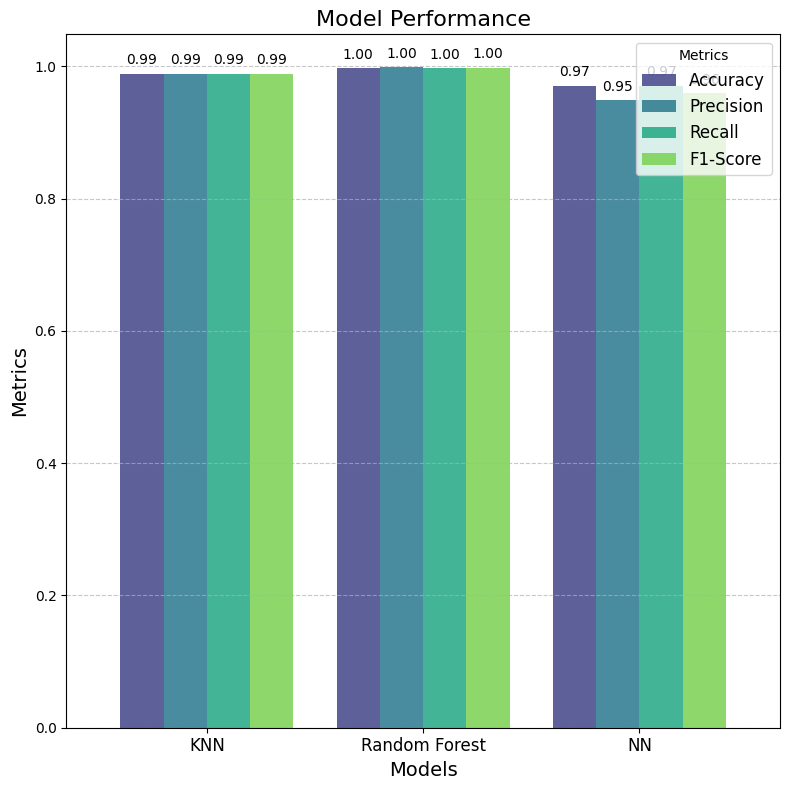

In [27]:
data = pd.DataFrame(models_metrics_dataset_agumentation).T 

best_per_metric = data.max()

plt.figure(figsize=(8, 8))
colors = sns.color_palette("viridis", len(data.columns))
bars = data.plot(kind='bar', figsize=(8, 8), width=0.8, alpha=0.85, color=colors)

# Notes on values
for p in bars.patches:
    bars.annotate(
        f'{p.get_height():.2f}', 
        (p.get_x() + p.get_width() / 2, p.get_height() + 0.01),
        ha='center', va='bottom', fontsize=10, color='black'
    )

plt.title("Model Performance", fontsize=16)
plt.ylabel("Metrics", fontsize=14)
plt.xlabel("Models", fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.legend(title="Metrics", fontsize=12, loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The values ​​obtained are the following.

In [31]:
print("Accuracy Random Forest:              " + str(models_metrics_dataset_agumentation['Random Forest']['Accuracy']))
print("Precision Random Forest:             " + str(models_metrics_dataset_agumentation['Random Forest']['Precision']))
print("Recall Random Forest:                " + str(models_metrics_dataset_agumentation['Random Forest']['Recall']))
print("F1-Score Random Forest:              " + str(models_metrics_dataset_agumentation['Random Forest']['F1-Score']))

print()
print()

print("Accuracy KNN:                        " + str(models_metrics_dataset_agumentation['KNN']['Accuracy']))
print("Precision KNN:                       " + str(models_metrics_dataset_agumentation['KNN']['Precision']))
print("Recall KNN:                          " + str(models_metrics_dataset_agumentation['KNN']['Recall']))
print("F1-Score KNN:                        " + str(models_metrics_dataset_agumentation['KNN']['F1-Score']))

print()
print()

print("Accuracy NN:                         " + str(models_metrics_dataset_agumentation['NN']['Accuracy']))
print("Precision NN:                        " + str(models_metrics_dataset_agumentation['NN']['Precision']))
print("Recall NN:                           " + str(models_metrics_dataset_agumentation['NN']['Recall']))
print("F1-Score NN:                         " + str(models_metrics_dataset_agumentation['NN']['F1-Score']))

Accuracy Random Forest:              0.9979889923793396
Precision Random Forest:             0.9985983393878977
Recall Random Forest:                0.9979889923793396
F1-Score Random Forest:              0.9982244198868327


Accuracy KNN:                        0.9906064775613886
Precision KNN:                       0.9907090578462862
Recall KNN:                          0.9906064775613886
F1-Score KNN:                        0.9906350160948829


Accuracy NN:                         0.9748359441151566
Precision NN:                        0.9574422467548963
Recall NN:                           0.9748359441151566
F1-Score NN:                         0.9658848122803023
